# Mounting drive



In [5]:
from google.colab import drive
from sys import path

drive.mount('/content/drive', force_remount=True)

root = '/content/drive/My Drive/nlp-lab'
path.append(root)

data_location = '/data/data-with-embeddings/not-contextualized-embeddings/xlm-mlm-ende-1024'

processed_amazon_english_data_location = root + data_location + '/amazon_english.json'
processed_amazon_german_data_location = root + data_location + '/amazon_german.json'
processed_organic_data_location = root + data_location + '/organic.json'

embedding_dim = 1024

Mounted at /content/drive


In [2]:
import numpy as np
import sklearn.metrics as metrics
import pandas as pd

import random
import copy
import json 

import torch
import torch.nn as nn
import torch.utils as utils
from torch import optim

from models.milnet import dataset, model, trainer

%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def read_data(processed_data_location):
  if processed_data_location is None:
    return None

  with open(processed_data_location) as json_file:      
      data_df = json_file.read() 
      data_df = json.loads(data_df)

  return pd.DataFrame(data_df)

In [7]:
amazon_en_df = read_data(processed_amazon_english_data_location)

In [8]:
amazon_de_df = read_data(processed_amazon_german_data_location)

In [9]:
organic_df = read_data(processed_organic_data_location)

In [10]:
sentiment_classes = {'n': 0, '0': 1, 'p': 2}
sentiment_labels = {0 : 'n', 1 : '0', 2 : 'p'}

last_column = str(embedding_dim - 1)

def parse_amazon_data(df, downsampling_factor=1):
  if df is None:
    return dataset.DocumentDataset((), ()), ()

  comments = []
  sentiments = []

  for comment_id, comment_df in df.groupby('comment_id'):
    nunique_sentiments = comment_df['comment_sentiment'].nunique()
    if (nunique_sentiments > 1):
      print('Found inconsitent sentiment'
            f'for the comment with id = {comment_id}')

    sentiment = comment_df['comment_sentiment'][0]
    if sentiment == 'p' and random.random() > downsampling_factor:
      continue

    comments.append(torch.Tensor(comment_df.loc[:, '0':last_column].values).to(device))
    sentiments.append(sentiment_classes[sentiment])

  sentiment_dataset = dataset.DocumentDataset(comments, sentiments)
  sentiments = torch.Tensor(sentiments).to(device)

  return sentiment_dataset, sentiments

amazon_en_dataset, amazon_en_sentiments = parse_amazon_data(amazon_en_df, 0.15)
amazon_de_dataset, amazon_de_sentiments = parse_amazon_data(amazon_de_df)

In [11]:
organic_embeddings = torch.Tensor(
    organic_df.loc[:, '0':last_column].values).to(device)
organic_sentiments = torch.Tensor(organic_df['sentence_sentiment'].apply(
    lambda sentiment: sentiment_classes[sentiment])).to(device)
organic_dataset = dataset.DocumentDataset(tuple(organic_embeddings.unsqueeze(1)),
                                          organic_sentiments)

In [12]:
datasets = {'amazon_en' : amazon_en_dataset, 'amazon_de': amazon_de_dataset,
            'organic': organic_dataset}

for label, dset in datasets.items():
  print(f'len({label}) = {len(dset)}')

len(amazon_en) = 4792
len(amazon_de) = 9897
len(organic) = 5084


In [13]:
full_stats = amazon_en_df.groupby('comment_id')['comment_sentiment'].agg(
    pd.Series.mode).value_counts()
sentiments, counts = amazon_en_sentiments.unique(return_counts=True, sorted=True)
for sentiment, count in zip(sentiments, counts):
  label = sentiment_labels[sentiment.item()]
  print(f'sentiment "{label}":')
  print(f'\tbefore downsampling -> {full_stats[label]}; '
        f'after downsampling -> {count.item()}')

sentiment "n":
	before downsampling -> 1372; after downsampling -> 1372
sentiment "0":
	before downsampling -> 1533; after downsampling -> 1533
sentiment "p":
	before downsampling -> 12605; after downsampling -> 1887


In [14]:
def split(dataset_to_split, splits=(0.8, 0.1, 0.1)):
  assert(sum(splits) == 1)
  n_comments = len(dataset_to_split)
  n_val = int(splits[1] * n_comments)
  n_test = int(splits[2] * n_comments)
  n_train = n_comments - n_val - n_test

  return utils.data.random_split(dataset_to_split, (n_train, n_val, n_test))

amazon_en_train, amazon_en_val, amazon_en_test = split(amazon_en_dataset)
organic_train, organic_val, organic_test = split(organic_dataset)

In [15]:
prepare_batch = lambda batch: trainer.prepare_batch(batch, device)

params = model.MilNetParams()

params.seg_emb_dim =  embedding_dim
params.seg_hidden_dim = 300
params.hidden_dim = 50
params.gru_layers = 10
params.attention_dim = 100
params.dropout_gru = 0.2
params.dropout_att = 0.2
params.dropout_seg = 0.2
params.classes_nb = 3

milnet = model.MilNet(params, train_embeddings=False).to(device)

In [16]:
def train(milnet, train_set, val_set, batch_size, optim_params, fit_params):
  train_loader = utils.data.DataLoader(train_set, batch_size=batch_size,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)
  val_loader = utils.data.DataLoader(val_set, batch_size=batch_size,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)

  dataloaders = {'train': train_loader, 'val': val_loader}

  optimizer = optim.Adam(milnet.parameters(), **optim_params)
  criterion = nn.NLLLoss()

  return trainer.fit(milnet, optimizer, criterion, dataloaders, **fit_params)

In [19]:
optim_params = {'lr': 5e-3, 'weight_decay': 1e-2}
#optim_params = best_param_dict
fit_params = {'nb_epochs': 200, 'patience': 50, 'print_every': 10}
milnet = model.MilNet(params, train_embeddings=False).to(device)

print("=====TRAIN ON AMAZON DATA=====")
_, amazon_train_losses, amazon_val_losses = train(milnet, amazon_en_train,
                                                  amazon_en_val,
                                                  batch_size=128,
                                                  optim_params=optim_params,
                                                  fit_params=fit_params)

torch.save(milnet.state_dict(), root + f'/models/milnet/state_dicts/xlm_no_finetune_{params.classes_nb}cl')

print("=====FINETUNE ON ORGANIC DATA=====")
_, organic_train_losses, organic_val_losses = train(milnet, organic_train,
                                                    organic_train,
                                                    batch_size=128,
                                                    optim_params=optim_params,
                                                    fit_params=fit_params)

=====TRAIN ON AMAZON DATA=====
Epoch  10/200 -> train loss: 8.25e-03, accuracy: 37.61%
Epoch  10/200 -> val loss: 6.76e-03, accuracy: 34.03%
Epoch  20/200 -> train loss: 8.23e-03, accuracy: 38.97%
Epoch  20/200 -> val loss: 6.83e-03, accuracy: 31.73%
Epoch  30/200 -> train loss: 8.19e-03, accuracy: 40.58%
Epoch  30/200 -> val loss: 6.78e-03, accuracy: 34.66%
Epoch  40/200 -> train loss: 8.22e-03, accuracy: 38.34%
Epoch  40/200 -> val loss: 6.69e-03, accuracy: 33.61%
Epoch  50/200 -> train loss: 8.18e-03, accuracy: 39.31%
Epoch  50/200 -> val loss: 6.76e-03, accuracy: 29.44%
Epoch  60/200 -> train loss: 8.09e-03, accuracy: 40.79%
Epoch  60/200 -> val loss: 6.80e-03, accuracy: 32.36%
Epoch  70/200 -> train loss: 8.25e-03, accuracy: 39.67%
Epoch  70/200 -> val loss: 6.85e-03, accuracy: 31.73%
Epoch  80/200 -> train loss: 8.00e-03, accuracy: 42.98%
Epoch  80/200 -> val loss: 6.53e-03, accuracy: 34.86%
Epoch  90/200 -> train loss: 8.12e-03, accuracy: 40.53%
Epoch  90/200 -> val loss: 6.87e-

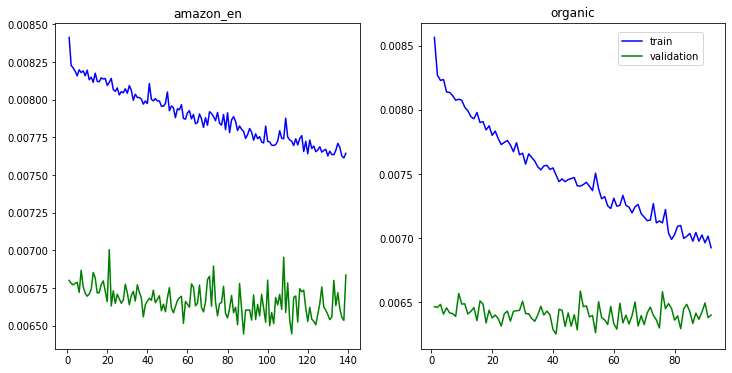

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(title, ax, train_losses, val_losses):
  epochs = np.arange(1, len(train_losses) + 1)
  ax.set_title(title)
  ax.plot(epochs, train_losses, color='blue', label='train')
  ax.plot(epochs, val_losses, color='green', label='validation')


fig, (ax_amazon_en, ax_organic) = plt.subplots(1, 2, figsize=(12,6))
plot_losses("amazon_en", ax_amazon_en, amazon_en_train_losses,
            amazon_en_val_losses)
plot_losses("organic", ax_organic, organic_train_losses, organic_val_losses)

handles, labels = ax_organic.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.82, 0.8))

fig.show()

In [ ]:
torch.save(milnet.state_dict(), root + f'/models/milnet/state_dicts/xlm_{params.classes_nb}cl')
milnet.load_state_dict(torch.load(root + f'/models/milnet/state_dicts/xlm_no_finetune_{params.classes_nb}cl'))

In [20]:
def get_results(test_set):
  test_loader = utils.data.DataLoader(test_set, batch_size=len(test_set),
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)
  for documents, classes in test_loader:
    predictions = milnet(documents).cpu().numpy()
    return (np.argmax(predictions, axis=1), classes.cpu().numpy())

AMAZON_EN = 'amazon_en'
AMAZON_DE = 'amazon_de'
ORGANIC = 'organic'
results = {}


milnet.eval()
with torch.set_grad_enabled(False):
  results[AMAZON_EN] = get_results(amazon_en_test)
  results[ORGANIC] = get_results(organic_test)
  if amazon_de_df is not None:
    results[AMAZON_DE] = get_results(amazon_de_dataset)

In [21]:
for dataset_name, (top1, labels) in results.items():
  print(f'=== {dataset_name} ===')
  print(f'F1-micro = {metrics.f1_score(labels, top1, average="micro")}')
  print(f'F1-macro = {metrics.f1_score(labels, top1, average="macro")}')
  confusion = metrics.confusion_matrix(labels, top1)
  sentiments = [sentiment_labels[i] for i in range(len(confusion))]
  row_format ="{:>5}" * (len(confusion) + 1)
  print()
  print(row_format.format("", *sentiments))
  for sentiment, row in zip(sentiments, confusion):
    print(row_format.format(sentiment, *row))
  print()

=== amazon_en ===
F1-micro = 0.33820459290187893
F1-macro = 0.28892494890070636

         n    0    p
    n   15   96   28
    0   20  112   27
    p   14  132   35

=== organic ===
F1-micro = 0.37795275590551175
F1-macro = 0.3554837422753964

         n    0    p
    n   26   47   68
    0   44   98   64
    p   32   61   68

=== amazon_de ===
F1-micro = 0.25250075780539555
F1-macro = 0.22117039324401733

         n    0    p
    n   92 2996 1054
    0   62 1456  515
    p   56 2715  951

